# Landfill Inference
This notebook is created for testing out the landfill detection AI model.

## Setup
Making sure that everything is in place.

In [1]:
import os
import dotenv
import boto3
dotenv.load_dotenv()

! export AWS_REGION=eu-west-1
! aws s3 ls --region=eu-west-1

client = boto3.client("sagemaker-runtime", region_name="eu-west-1")



An error occurred (InvalidToken) when calling the ListBuckets operation: The provided token is malformed or otherwise invalid.


## Config
Configuring Global variables

In [2]:
DATA_PATH=".in"
ENDPOINT_NAME = "scrnts-dev-landfill-yolo-endpoint"

## Prepare Payload

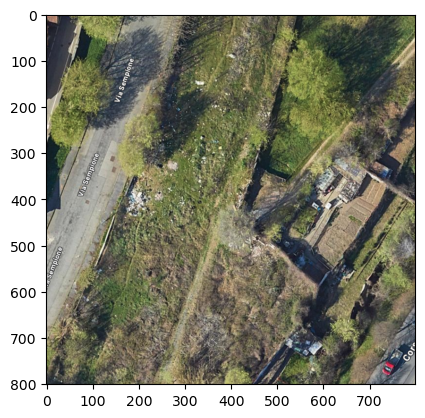

In [3]:
import base64
import cv2
from matplotlib import pyplot as plt
import numpy as np


img_name = "inference-5.png"
image_base64 = None

# Open image as base64
image_path = os.path.join(DATA_PATH, img_name)
with open(image_path, "rb") as image_file:
    image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# image_cv2 = cv2.imread(image_path)
# image_cv2_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

jpg_original = base64.b64decode(image_base64)
jpg_as_np = np.frombuffer(jpg_original, dtype=np.uint8)
image_cv2 = cv2.imdecode(jpg_as_np, flags=-1)
image_cv2_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

plt.imshow(image_cv2_rgb)
plt.show()

### Create local inference model

In [5]:
import numpy as np
import torch
from ultralytics import YOLO

model = YOLO(model='.in/2025-02-10.pt', task='predict')
# model = YOLO(model='.in/yolo11m.pt', task='predict')

inference = model.predict(image_cv2_rgb, conf=0.1)


0: 800x800 4 dumping-sitess, 186.5ms
Speed: 3.9ms preprocess, 186.5ms inference, 7.4ms postprocess per image at shape (1, 3, 800, 800)


In [6]:
import json

infer = {"inference": []}
for res in inference:
    res_dict = json.loads(res.to_json())
    for res_item in res_dict:
        infer["inference"].append(
            {"confidence": res_item["confidence"], "bbox": res_item["box"]}
        )

json.dumps(infer)

'{"inference": [{"confidence": 0.1671, "bbox": {"x1": 436.73248, "y1": 333.96637, "x2": 531.18964, "y2": 441.87683}}, {"confidence": 0.1395, "bbox": {"x1": 27.52117, "y1": 30.37648, "x2": 778.09515, "y2": 794.89758}}, {"confidence": 0.13672, "bbox": {"x1": 166.72487, "y1": 353.56543, "x2": 238.38739, "y2": 443.03369}}, {"confidence": 0.11537, "bbox": {"x1": 682.54901, "y1": 83.29514, "x2": 800.0, "y2": 235.85831}}]}'

436.73248| 333.96637| 531.18964| 441.87683| 0.1671| landfill
27.52117| 30.37648| 778.09515| 794.89758| 0.1395| landfill
166.72487| 353.56543| 238.38739| 443.03369| 0.13672| landfill
682.54901| 83.29514| 800.0| 235.85831| 0.11537| landfill


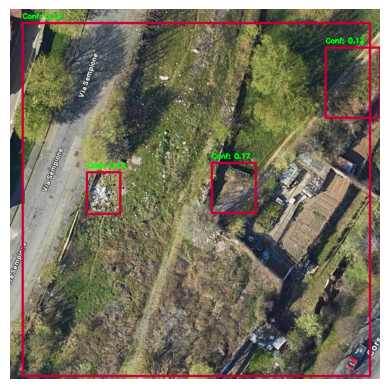

In [7]:
import copy

# Define a temp image to be modified
temp_image = copy.deepcopy(image_cv2_rgb)

for inf in infer["inference"]:
    box = inf["bbox"]

    conf = inf["confidence"]
    cls = "landfill"
    print("| ".join([str(box["x1"]), str(box["y1"]), str(box["x2"]), str(box["y2"]), str(conf), str(cls)]))
    cv2.rectangle(temp_image, (int(box["x1"]), int(box["y1"])), (int(box["x2"]), int(box["y2"])), (200, 0, 50), 3)
    label = f"Conf: {conf:.2f}"
    cv2.putText(
        temp_image,
        label,
        (int(box["x1"]), int(box["y1"]) - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2,
    )
plt.imshow(temp_image)
plt.axis("off")
plt.show()